# Rt Live Model

In [1]:
from matplotlib import pyplot as plt
from datetime import datetime
import pandas as pd
import pymc3 as pm
import numpy as np
import arviz as az
import sys
import re

sys.path.append('..')

In [2]:
from covid.models.generative import GenerativeModel
from covid.data import get_tx_covid_data, summarize_inference_data

### Texas county data

Get data on Texas counties and summarize

In [3]:
new_cases, new_tests = get_tx_covid_data()

In [70]:
# Get Texas-wide data from covid tracking project
tx_data = pd.read_csv('https://covidtracking.com/api/v1/states/tx/daily.csv')
tx_data = tx_data.set_index(
    tx_data['date'].map(
        lambda x: datetime.strptime(str(x), '%Y%m%d'))
).sort_index()

In [23]:
# Get positives and test counts for Houston area
region = 'Houston'
counties = ['Harris', 'Montgomery', 'Fort Bend', 'Brazoria', 'Galveston']

df = pd.concat(
    [new_cases.loc[counties].sum(), 
     new_tests.loc[counties].sum()],
    axis=1
)
df.columns = ['positive', 'total']

In [74]:
# Guess at test totals from all-Texas totals
TX_DATA_START = pd.Timestamp('2020-03-17')
TX_DATA_END = pd.Timestamp('2020-04-21')

df.loc[TX_DATA_START:TX_DATA_END, 'total'] = tx_data.loc[
    TX_DATA_START:TX_DATA_END, 'total'] * df.loc[
    TX_DATA_END + pd.Timedelta(days=1), 'total'] / tx_data.loc[
    TX_DATA_END + pd.Timedelta(days=1), 'total']

LAST_DAY = max(new_cases.columns[-1], 
               new_tests.columns[-1])

if np.isnan(df.loc[LAST_DAY, 'total']):
    df.loc[LAST_DAY, 'total'] = tx_data.loc[
        LAST_DAY, 'total'] * df.loc[
        LAST_DAY - pd.Timedelta(days=1), 'total'] / tx_data.loc[
        LAST_DAY - pd.Timedelta(days=1), 'total']

## Run Generative Model

In [76]:
gm = GenerativeModel(region, df.loc[TX_DATA_START:LAST_DAY])
gm.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 378 seconds.


In [77]:
result = summarize_inference_data(gm.inference_data)

In [78]:
result

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-03-08,1.960292,1.948814,1.665308,2.281532,174.395662,0.000000,0.000000,0.0,0.000000
2020-03-09,1.949242,1.930954,1.689791,2.278623,2.436845,0.000000,0.000000,0.0,0.000000
2020-03-10,1.933433,1.915824,1.692792,2.246097,34.558269,0.000000,0.000000,0.0,0.000000
2020-03-11,1.918091,1.913530,1.658202,2.178290,65.833198,0.000000,0.000000,0.0,0.000000
2020-03-12,1.898459,1.892762,1.629492,2.150001,73.084898,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...
2020-07-01,1.111414,1.100709,0.842170,1.316171,1171.860594,1179.102512,853.664048,1156.0,8291.000000
2020-07-02,1.110939,1.098351,0.814866,1.300130,1207.770128,1210.587614,1159.136289,2021.0,10675.000000
2020-07-03,1.112378,1.095018,0.832587,1.323950,1246.260967,1242.501427,1187.426059,1767.0,9111.000000


# Plot Results

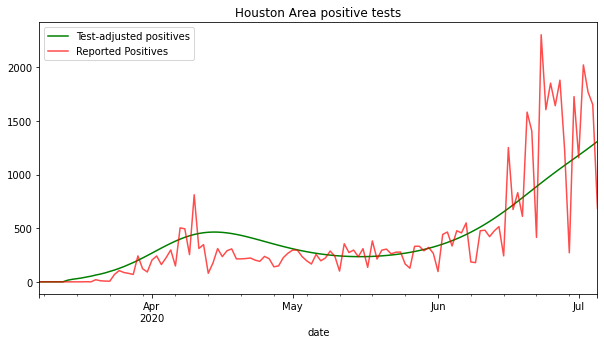

In [79]:
fig, ax = plt.subplots(figsize=(10,5))
result['test_adjusted_positive'].plot(c="g", label="Test-adjusted positives")
result['positive'].plot(c='r', alpha=.7, label="Reported Positives")
ax.set_title(f'{region} Area positive tests')
fig.set_facecolor('w')
ax.legend()
plt.show()

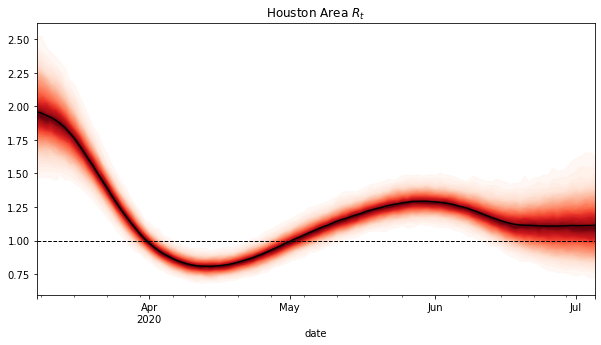

In [80]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"{region} Area $R_t$")
samples = gm.trace['r_t']
x=result.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

result["mean"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
fig.set_facecolor('w')
plt.show()